# <center> BERT with Sparse Attention

Many of the recent advances in NLP have come largely due to the fact that the size of these models is simply getting larger. There are many models that work excellently, but need to be run on a configuration of 8+ high-end GPUs or TPUs, making it extremely difficult for the average consumer or developer to play around with these models and come up with new advances and ideas of their own. However, recent work, such as that seen in the [Longformer paper](https://arxiv.org/pdf/2004.05150.pdf), suggests that the attention mechanism that is present in these language models does not need to be dense, and can be employed with sparse matrix operations in order to increase the context length. Furthermore, signs point to the idea that the new [GPT 4 Turbo model](https://help.openai.com/en/articles/8555510-gpt-4-turbo) employs these sparse matrix operations in order to increase its context window. The attention mechanism employed by these transformer models has become the staple for NLP ever since the release of the ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762.pdf) paper. However, with the introduction of working sparse attention models, a new question arises: **How much attention do we really need?**. In this project, I aim to use the `pytorch-block-sparse` package in order to implement this sparse attention mechanism into the existing base BERT model, following the sparsity pattern outlined in the Longformer paper. However, in contrast to that paper, by doing this I aim to decrease the overall size of the BERT model instead of trying to increase the model's context length.

## Converting to Dense-Sparse

First, we try converting the attention layers of the BERT model into dense representations of the sparse attention pattern

### Load the base BERT model

In [1]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("bert-base-uncased")

In [2]:
bert    # Look at the structure of the model  

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Testing with a single layer

We first test converting a single attention layer (including the Q, K, and V weights) to sparse versions. Here, the tensors themselves are still dense, but weights that would be 0 in the true sparse matrix are set as such.

In [3]:
# Grab the 0th attention mechanism
attn0 = bert.encoder.layer[0].attention.self
attn0

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [4]:
Q, K, V = attn0.query.weight.data, attn0.key.weight.data, attn0.value.weight.data
Q

tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0154,  0.0768,  0.0548],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0527,  0.1393,  0.0078],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0279,  0.0258, -0.0468],
        ...,
        [-0.0085,  0.0514,  0.0555,  ...,  0.0282,  0.0543, -0.0541],
        [-0.0198,  0.0944,  0.0617,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0015, -0.0952,  0.0099,  ..., -0.0191, -0.0508, -0.0085]])

##### Define the Sparsity Structure

We focus on using the sliding window structure for the attention mechanism. 

In [5]:
import torch

def get_sliding_window(weights, window_size=4):
    """
    Keep only the weights within a specified window along the diagonals of the attention weight tensor.

    Parameters:
        weight (torch.Tensor): Attention weight tensor
        window_size (int): Size of the window along the diagonals

    Returns:
        (torch.Tensor): Sparse attention weight tensor with values outside the window set to 0
    """
    assert weights.dim() == 2, "Input tensor must be 2D"
    assert weights.size(0) == weights.size(1), "Input tensor must be square"
    assert window_size % 2 == 0, "Window size must be an even number"

    # Create mask
    idx = torch.arange(weights.size(0))
    diag_idx = idx.unsqueeze(0) - idx.unsqueeze(1)
    mask = diag_idx.abs() < window_size//2 + 1

    return weights * mask.float()

In [6]:
get_sliding_window(Q, 2)

tensor([[-0.0164,  0.0261, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0334,  0.0109,  ..., -0.0000,  0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  0.0282,  0.0543, -0.0000],
        [-0.0000,  0.0000,  0.0000,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0508, -0.0085]])

### Convert All Attention Layers

We convert each attention layer of the base BERT model to a dense-sparse version using a sliding window sparsity. The weights are not truly sparse, we just set values to zero that do not fall along the sliding window.

In [7]:
def dense_sparse_convert(model, sparsify_fn, **kwargs):
    """Replace the dense attention weights in a model with sparse ones."""
    for bert_layer in model.encoder.layer:
        attn = bert_layer.attention.self
        attn.query.weight.data = sparsify_fn(attn.query.weight.data, **kwargs)
        attn.key.weight.data = sparsify_fn(attn.key.weight.data, **kwargs)
        attn.value.weight.data = sparsify_fn(attn.value.weight.data, **kwargs)
    return model

In [8]:
window_size = 64
sparse_bert = dense_sparse_convert(bert, get_sliding_window, window_size=window_size)

In [9]:
sparse_bert     # Verify the integrity of the model structure

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [10]:
sparse_bert.encoder.layer[0].attention.self.query.weight.data  # The weights are sparsified successfully

tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0000,  0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  0.0282,  0.0543, -0.0541],
        [-0.0000,  0.0000,  0.0000,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0191, -0.0508, -0.0085]])

## Convert to Block Sparse

Using the `pytorch-block-sparse` package, I convert the dense-sparse attention layers to truly sparse linear modules. The package already has a way to initialize a sparse linear layer from a dense one; however, it is meant to be used with fully dense layers and a provided density ratio, thus implementing sparsity in its own way. Here, I want to maintain the chosen sparsity pattern, essentially creating a block sparse matrix, where blocks of zeros are not stored. In order to do that, I rewrite some of the class itself, allowing it to call methods of the `BlockSparseMatrix` class and define where the sparse blocks lie.

In [11]:
from pytorch_block_sparse import BlockSparseMatrix

def get_blocks(weights, block_shape):
    """Returns the block indices for a sliding window pseudo-sparse weight matrix."""
    window_size = compute_window_size(weights)
    half_window = window_size // 2

    assert half_window % block_shape[0] == 0, "Half window must be divisible by block shape"
    blocks_per_window = half_window // block_shape[0]

    # Create block mask
    X, Y = BlockSparseMatrix.blocks_count_(weights.size(), block_shape)
    diag_idx = torch.arange(X).unsqueeze(0) - torch.arange(Y).unsqueeze(1)
    return (diag_idx.abs() <= blocks_per_window).nonzero()

def compute_window_size(weights):
    """Compute the window size for a psuedo-sparse weight matrix."""
    assert weights.dim() == 2, "Input tensor must be 2D"
    assert weights.size(0) > 0 and weights.size(1) > 0, "Input tensor must be non-empty"
    
    return (weights[0].nonzero().max().item()) * 2

def compute_density(sparse_weights):
    """Compute the density of a psuedo-sparse weight matrix."""
    total_size = sparse_weights.shape[0] * sparse_weights.shape[1]
    sparse_size = sparse_weights.data.shape[0]  * sparse_weights.data.shape[1] 
    return sparse_size / total_size

In [12]:
from pytorch_block_sparse import BlockSparseLinear, BlockSparseMatrix
from pytorch_block_sparse.block_sparse_linear import BlockSparseLinearFunction
from torch import nn

class BlockSparseFromLinear(BlockSparseLinear):
    """Our implementation of the BlockSparseLinear layer. 
    Requires the external get_blocks and compute_window_size functions.
    """
    OPTIMIZED_BLOCK_SIZE = 32

    def __init__(
        self,
        torch_nn_linear,        # Only use values from the linear layer (no in_size, out_size, bias, etc.)
        verbose = False,
        **kwargs                # Pass any additional arguments to the sparsify function
    ):
        super(BlockSparseLinear, self).__init__()
        self.fn = BlockSparseLinearFunction.apply
        self.verbose = verbose
        self.block_shape = (self.OPTIMIZED_BLOCK_SIZE, self.OPTIMIZED_BLOCK_SIZE)   # Modify to always set block size to optimal (32x32)
        self._optimized = (
            self.block_shape[0] == self.OPTIMIZED_BLOCK_SIZE and self.block_shape[1] == self.OPTIMIZED_BLOCK_SIZE
        )

        # Modify to use values from the linear layer
        in_features = torch_nn_linear.in_features
        out_features = torch_nn_linear.out_features
        bias = torch_nn_linear.bias is not None
        weight = torch_nn_linear.weight.data

        if in_features % self.block_shape[1] != 0:
            raise Exception(
                f"BlockSparseLinear invalid block_shape={self.block_shape[1]}, should be divisor of {in_features}"
            )
        if out_features % self.block_shape[0] != 0:
            raise Exception(
                f"BlockSparseLinear invalid block_shape={self.block_shape[0]}, should be divisor of {out_features}"
            )
        self.in_features = in_features
        self.out_features = out_features

        # Get the block indices and number of blocks
        blocks = get_blocks(weight, self.block_shape)
        self.block_count = len(blocks)
        
        with torch.no_grad():
            weight = BlockSparseMatrix.from_dense(weight, self.block_shape, self.block_count, blocks=blocks)

        self.weight = weight

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features, device="cuda"))
            with torch.no_grad():
                self.bias.copy_(torch_nn_linear.bias)
        else:
            self.register_parameter("bias", None)


In [13]:
sparse_Q = sparse_bert.encoder.layer[0].attention.self.query
sparse_Q.weight

Parameter containing:
tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0000,  0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  0.0282,  0.0543, -0.0541],
        [-0.0000,  0.0000,  0.0000,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0191, -0.0508, -0.0085]],
       requires_grad=True)

In [14]:
from pytorch_block_sparse import BlockSparseLinear

# Try on a single pseudo-sparse weight matrix
sparse_Q_linear = BlockSparseFromLinear(torch_nn_linear=sparse_Q)
sparse_Q_linear

BlockSparseFromLinear(
  (weight): BlockSparseMatrix(shape=torch.Size([768, 768]), cols=torch.Size([70, 2]), row_start_ends_a=torch.Size([25]), data=torch.Size([2240, 32]), block_shape=(32, 32))
)

In [15]:
print("Sparsity =", 1-compute_density(sparse_Q_linear.weight))

Sparsity = 0.8784722222222222


In [16]:
torch.allclose(sparse_Q.weight, sparse_Q_linear.weight.to_dense())

/home/yungdankblast/SparseAttention/.venv/lib/python3.10/site-packages/pytorch_block_sparse-0.1.2-py3.10-linux-x86_64.egg/pytorch_block_sparse/block_sparse.py:414: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  out = torch.sparse.FloatTensor(


True

From the above outputs, we can see that we are now successfully storing the weight matrix using sparse block matrix form. With our window size of 64 and our block size of 32x32 (which is the optimal size defined by the package), we get 70 total blocks. This results in a sparsity of almost 88%. We will now go ahead and convert the rest of the attention layers in the BERT model to the sparse block matrix form.

### Convert the model

In [17]:
def sparse_convert(sparse_model, **kwargs):
    """Convert the psuedo-sparse attention weights in a model to block sparse ones."""
    for layer in sparse_model.encoder.layer:
        attn = layer.attention.self
        attn.query = BlockSparseFromLinear(attn.query, **kwargs)
        attn.key = BlockSparseFromLinear(attn.key, **kwargs)
        attn.value = BlockSparseFromLinear(attn.value, **kwargs)
    return sparse_model

In [18]:
block_sparse_bert = sparse_convert(sparse_bert)
block_sparse_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): BlockSparseFromLinear(
              (weight): BlockSparseMatrix(shape=torch.Size([768, 768]), cols=torch.Size([70, 2]), row_start_ends_a=torch.Size([25]), data=torch.Size([2240, 32]), block_shape=(32, 32))
            )
            (key): BlockSparseFromLinear(
              (weight): BlockSparseMatrix(shape=torch.Size([768, 768]), cols=torch.Size([70, 2]), row_start_ends_a=torch.Size([25]), data=torch.Size([2240, 32]), block_shape=(32, 32))
            )
            (value): BlockSparseFromLinear(
   

## Compare the Models

Here, I compare the base BERT model and the sparse one. I look at total sparsity and run time for a forward pass through the model.

### Sparsity

In [19]:
# Re-initialize the base BERT model
bert = AutoModel.from_pretrained("bert-base-uncased")

In [20]:
bert_total_params = bert.num_parameters()
block_sparse_bert_total_params = block_sparse_bert.num_parameters()
print("Number of parameters in the dense model:", bert_total_params)
print("Number of parameters in the sparse model:", block_sparse_bert_total_params)
print("Total sparsity:", 1 - block_sparse_bert_total_params / bert_total_params)

Number of parameters in the dense model: 109482240
Number of parameters in the sparse model: 90829056
Total sparsity: 0.17037634597173024


Unfortunately, though our attention layers had a sparsity of almost 88%, since we only made the attention layers sparse, the sparsity of the total model is only around 17%, meaning that we have not significant reduced the size of the model. We could look into making the other layers of the model sparse, but it is unclear as to what type of sparsity pattern that we should use. Furthermore, the block sparse pattern that we are using now still has disadvantages, since we still end up saving a good number of zero values. A more optimal storage would be a diagonal sparse matrix representation, where diagonals and off-diagonals are stored as vectors. We compute the sparsity of that storage type below.

In [21]:
# Assume a window size of 64
window_size = 64
offsets = torch.arange(-window_size//2, window_size//2+1)
sparse_diag_Q = [sparse_Q.weight.data.diag(off) for off in offsets]

In [22]:
# Compute sparsity
sparse_diag_params = sum(len(d) for d in sparse_diag_Q)
total_params = 768 * 768
print("Number of parameters in a single attention layer in the dense model:", total_params)
print("Number of parameters in a single attention layer in the sparse model:", sparse_diag_params)
print("Sparsity:", 1 - sparse_diag_params / total_params)

Number of parameters in a single attention layer in the dense model: 589824
Number of parameters in a single attention layer in the sparse model: 48864
Sparsity: 0.9171549479166666


Thus, with a diagonal sparse matrix, we can get up to almost 92% sparsity in each attention layer. Unfortunately, we are storing the weights in a list here, and tensors have a more defined shape, and so we would likely need to store the diagonals with some zero values if we wanted to store them all on a single tensor for ease in forward computation. This structure also lends itself to sliding window attention patterns with a dilation factor, where cerain tokens are skipped and ignored, as seen in the Longformer paper. This kind of attention pattern could not be efficiently stored in a block-sparse form, as the resulting sparse attention matrix would have alternating diagonals of weights and zeros.

However, using this optimized storage method would not change much in the number of overall parameters, and we would still have a sparsity of only around 18% on the total model. Therefore, in order to truly reduce the size of the model, we would likely have to sparsify other layers within the BERT model. In the following code block, I use the built-in `BlockSparseModelPatcher` of the `pytorch-block-sparse` package to sparsify other layers in BERT while maintaining the sparsity pattern we set previously for the attention layers.

#### Sparse patching BERT on non-Attention layers

In [23]:
from pytorch_block_sparse import BlockSparseModelPatcher

# Re-initialize sparse BERT
full_sparse_bert = AutoModel.from_pretrained("bert-base-uncased")
full_sparse_bert = sparse_convert(dense_sparse_convert(full_sparse_bert, get_sliding_window, window_size=64))

# Create a model patcher
mp = BlockSparseModelPatcher()

# Use increasing density as the layer index increases
mp.add_pattern("encoder\.layer\.[0-6]\.intermediate\.dense", {"density":0.25})
mp.add_pattern("encoder\.layer\.[0-6]\.output\.dense", {"density":0.25})
mp.add_pattern("encoder\.layer\.[0-6]\.attention\.output\.dense", {"density":0.25})
mp.add_pattern("encoder\.layer\.[7-9]+\.intermediate\.dense", {"density":0.5})
mp.add_pattern("encoder\.layer\.[7-9]+\.output\.dense", {"density":0.5})
mp.add_pattern("encoder\.layer\.[7-9]+\.attention\.output\.dense", {"density":0.5})
mp.patch_model(full_sparse_bert)

Patching with BlockSparseLinear 'encoder.layer.0.attention.output.dense' with density=0.25, in=768, out=768,bias=True 
Patching with BlockSparseLinear 'encoder.layer.0.intermediate.dense' with density=0.25, in=768, out=3072,bias=True 
Patching with BlockSparseLinear 'encoder.layer.0.output.dense' with density=0.25, in=3072, out=768,bias=True 
Patching with BlockSparseLinear 'encoder.layer.1.attention.output.dense' with density=0.25, in=768, out=768,bias=True 
Patching with BlockSparseLinear 'encoder.layer.1.intermediate.dense' with density=0.25, in=768, out=3072,bias=True 
Patching with BlockSparseLinear 'encoder.layer.1.output.dense' with density=0.25, in=3072, out=768,bias=True 
Patching with BlockSparseLinear 'encoder.layer.2.attention.output.dense' with density=0.25, in=768, out=768,bias=True 
Patching with BlockSparseLinear 'encoder.layer.2.intermediate.dense' with density=0.25, in=768, out=3072,bias=True 
Patching with BlockSparseLinear 'encoder.layer.2.output.dense' with density

In [24]:
full_sparse_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-6): 7 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): BlockSparseFromLinear(
              (weight): BlockSparseMatrix(shape=torch.Size([768, 768]), cols=torch.Size([70, 2]), row_start_ends_a=torch.Size([25]), data=torch.Size([2240, 32]), block_shape=(32, 32))
            )
            (key): BlockSparseFromLinear(
              (weight): BlockSparseMatrix(shape=torch.Size([768, 768]), cols=torch.Size([70, 2]), row_start_ends_a=torch.Size([25]), data=torch.Size([2240, 32]), block_shape=(32, 32))
            )
            (value): BlockSparseFromLinear(
     

In [25]:
print(f"Final model parameters count={full_sparse_bert.num_parameters()}")
print(f"Final model sparsity={1 - full_sparse_bert.num_parameters() / bert_total_params}")

Final model parameters count=54997248
Final model sparsity=0.49766055206762305


So by adding some sparsity to other linear layers within the encoder part of the model, we were able to get the total model sparsity to almost 50%. Now, unfortunately, I have no way of figuring out whether I made the layers too sparse, or whether they could be more sparse and still retain some of their performance. Though I was unable to implement them here, I did see some preliminary research online into models that can learn sparsity, choosing how sparse to make themselves as they are trained. It would be worth looking into these types of models for the other linear layers in the encoder structure.

### Run time

In [26]:
from datasets import load_dataset

# Initialize a data subset for testing (This data has been preprocessed and tokenized already)
wikipedia = load_dataset("cayjobla/wikipedia-pretrain-processed", split="train[:10000]")
wikipedia

Resolving data files:   0%|          | 0/222 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label'],
    num_rows: 10000
})

In [27]:
bert = AutoModel.from_pretrained("bert-base-uncased")   # Reinitialize the dense model

To test the time it takes for a forward pass of the model, I run multiple batches from the training data on each of the models and analyze the computation times of each.

In [28]:
import time

def batch_data(data, batch_size=8):
    """Batch the data into batches of the specified size."""
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

def run_test(model, data, batch_size=16, device="cuda"):
    """Run a forward pass on the model with the given data."""
    model.to(device)

    times = []
    for batch in batch_data(data, batch_size=batch_size):
        input_ids = torch.tensor(batch["input_ids"]).to(device)
        attention_mask = torch.tensor(batch["attention_mask"]).to(device)
        token_type_ids = torch.tensor(batch["token_type_ids"]).to(device)
    
        start = time.time()
        model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        times.append(time.time() - start)
    
    model.to("cpu")
    return times

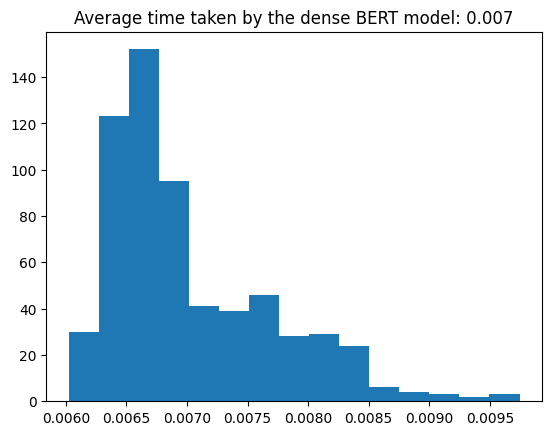

In [30]:
from matplotlib import pyplot as plt
import numpy as np

bert_time = run_test(bert, wikipedia, batch_size=16, device="cuda")
plt.hist(bert_time, bins=15)
plt.title(f"Average time taken by the dense BERT model: {round(np.mean(bert_time), 4)}")
plt.show()

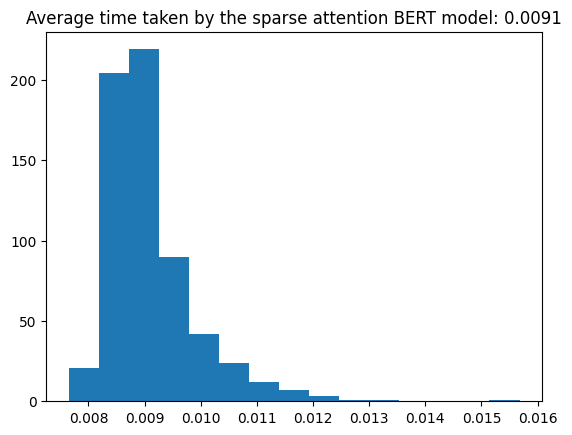

In [31]:
sparse_bert_time = run_test(sparse_bert, wikipedia, batch_size=16, device="cuda")
plt.hist(sparse_bert_time, bins=15)
plt.title(f"Average time taken by the sparse attention BERT model: {round(np.mean(sparse_bert_time), 4)}")
plt.show()

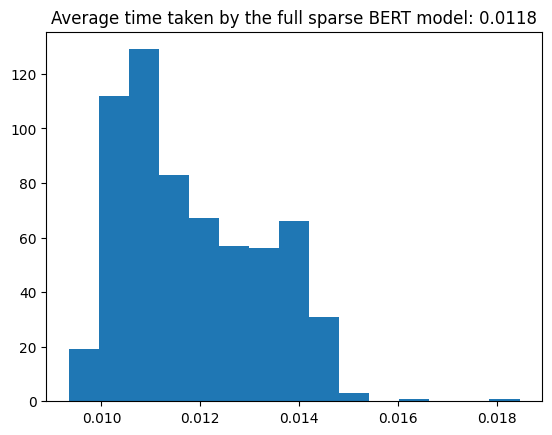

In [32]:
full_sparse_bert_time = run_test(full_sparse_bert, wikipedia, batch_size=16, device="cuda")
plt.hist(full_sparse_bert_time, bins=15)
plt.title(f"Average time taken by the full sparse BERT model: {round(np.mean(full_sparse_bert_time), 4)}")
plt.show()

From the above, it appears that the more sparse that a model is, the longer that it takes on average to run a batch of 16 training examples through the model. This is interesting, since we would expect the more sparse models to run faster since they are performing fewer FLOPS for each forward run through the model. Likely, this discrepancy is a result of the fact that dense tensor operations have been optimized over many years of use; whereas sparse matrix operations on GPUs are still being optimized and developed currently. Thus, while more total FLOPs are being done under the dense model, perhaps those FLOPs are much easier to parallelize on the GPU when compared to the sparse matrix operations.

## Fine-tuning the Sparse Model

Here, I attempt to fine-tune the sparse model using the COLA task data from the GLUE benchmark dataset. This way, I can compare the results of the sparse model to the base BERT model, and determine how much performance is lost when making the attention mechanism sparse. In order to fine-tune the model, I use a modified version of a script that I have written for a different project. The script used here is called `finetune_sparse_bert.py`, and it can be found at my [Github repo](https://github.com/CayJoBla/SparseAttention) for this project.

In [34]:
!python finetune_sparse_bert.py \
  --tokenizer bert-base-uncased \
  --task cola \
  --batch_size 16 \
  --learning_rate 3e-5 \
  --num_epochs 3 \
  --logging_steps 100 \
  --output_dir bert-base-uncased-sparse-64 \
  --run_name sparse-glue-cola \
  --seed 916 \
  -v

Loading the 'cola' split of the 'glue' dataset...
Loading bert-base-uncased tokenizer...
Loading bert-base-uncased model...
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Sparsifying bert-base-uncased model...
Defining training arguments...
Preprocessing the dataset for the 'cola' task...
Running tokenizer on dataset: 100%|█| 1043/1043 [00:00<00:00, 14668.25 examples/
Load the evaluation metric for the 'cola' task...
Initialize Trainer...
Train the model...
 91%|███████████████████████████████████████    | 60/66 [00:01<00:00, 38.15it/s]
                                                                                
{'eval_loss': 0.6782962679862976, 'eval_matthews_correlation': 0.0, 'eval_runtime': 1.723, 'eval_samples_per_second': 605.333, 'ev

From the training above, we got a matthew's correlation (the metric for this task) of 0.0974. Unfortunately, according to the [GLUE leaderboard](https://gluebenchmark.com/leaderboard) the matthew's correlation for the base BERT model is generally between 0.55 and 0.6, so we are severely underperforming with this sparse model. Therefore, it appears that the sparse attention model on this context length does not give us great performance on the BERT model.

## Results, Analysis, and Conclusion

### Synopsis

In this project, we took the base BERT model and applied a sliding window sparsity pattern to the attention layers of the model with the goal of reducing the size of the model instead of increasing the model's context length. First, we applied the sparsity pattern to the dense linear attention layers, keeping the remaining weights as they are found in the base BERT model. Next, from the psuedo-sparse dense layers, we created true block-sparse linear layers using a modified version of the `BlockSparseLinear` module found in the `pytorch-block-sparse` package. Comparing the resulting sparse attention BERT model to the base BERT model, we found that despite the fact that our attention layers had a sparsity of around 88%, the entire sparse attention model only had a sparsity of around 17% due to the existence of many larger dense linear layers within the model. Because of this, we decided to try using the `BlockSparseModelPatcher` from the `pytorch-block-sparse` package to apply random block sparsity to the other dense BERT model layers. Though we cannot be sure of the performance of the fully sparse model, we applied decreasing sparsity to the successive encoder layers (25% -> 50% -> 100% density), reaching a total model sparsity of around 50%. Next, we compared the run times of the different models (the dense BERT model, the sparse attention BERT model, and the fully sparse BERT model), and found that--in contrast to our expectations--the sparser models on average took longer to do a forward pass with a batch of 16 training samples than the denser models. After running these comparisons of sparsity and run time, we finally decided to compare the performance of the sparse attention BERT model to the base BERT model on the COLA task from the GLUE benchmark dataset. After fine-tuning for a few epochs on this task, we found that the sparse attention model performed significantly worse than the dense model (according to the matthew's correlation metric), getting a score of 0.09 while the base BERT model generally scores around 0.55-0.60.

### Analysis

All-in-all, it seems that sparse attention layers as they currently stand are not an efficient way to reduce the size of a model while maintaining its performance. There are a variety of reasons as to why that may be:
1. The attention sparcity pattern that we employed only used a sliding window, and it did not take into account dilation in the sliding windows or the use of global attention for certain tokens, as was used in the Longformer paper. The reason for this is that the block-sparse matrix implementation that we decided to use would not work well with these sparsity patterns, and would result in blocks within the attention mechanism that were themselves psuedo-sparse (densely-stored blocks, but with lots of zeros).
2. The sparse matrix operations are not as efficient as those for dense matrices. At the point of writing this conclusion, research is being done into a variety of different implementations of sparse matrix operations within CUDA; however, many of them still suffer from inefficiencies. Recently, NVIDIA has released multiple articles, such as [this one](https://developer.nvidia.com/blog/accelerating-matrix-multiplication-with-block-sparse-format-and-nvidia-tensor-cores/), about recent advances with block-sparse matrix operations on NVIDIA GPUs; however, not much work has been done yet on getting those to work well with Pytorch. In fact, the provided article recommends the package that we used as the Pytorch implementation of block-sparse matrix operations, depite the fact that the package was last updated in 2020.
3. While the block-sparse matrix format is probably the best sparse implementation for large networks, it is not the best way to store sparse matrices for sliding-window attention. Since the sliding window sparse attention pattern deals with diagonals, it would be better suited to a form of sparse matrix that stores the diagonal and off-diagonals of the layer as vectors. This way, no unnecessary values are stored, and sparsity can be maximized in those layers. Unfortunately, because this is not a common sparse matrix type, it likely will not get a ton of research, and so the sparse matrix operations for this form will not be very efficient either.
4. Perhaps the sparse attention model did not perform well because it needed more training time. Here, we only fine-tuned the model, since it was initialized with the weights from the base BERT model, but it is possible that the sparse model needs enough data to again pretrain the model since the model format has changed so drastically.
5. While the sparse attention form worked well for the long context models in the Longformer paper and (potentially) GPT 4 Turbo, it is possible that the sparse attention pattern is not suited for smaller context sizes, and long context models only benefit from the sparsity *because* of their longer context. It is possible that for shorter context lengths, more attention needs to be placed on the tokens so that the meaning can be better extracted from the smaller context.

### Future Research

With more time and resources, I would look at first implementing global attention alongside the sliding window attention, as seen in the Longformer document, and train the sparse model for a much longer time to determine whether the performance of the model can be improved to the level of the base BERT model. If significant improvement can be made, more research should be done into diagonal-sparse matrices and optimizing the sparse matrix operations for those matrices on the GPU so that models can be sparsified while maintaining or decreasing run time. Furthermore, while doing this project, I came across a few WIP implementations of linear layers for these models that can learn sparsity. If this idea appears to work decently well, some more research should be done into this idea so that other non-attention layers of these language models can be made sparse without drastically impacting the overall model performance.